# NARR: Subsetting and OPeNDAP

## About the Dataset

This tutorial uses data from NOAA's [North American Regional Reanalysis](https://www.ncei.noaa.gov/products/weather-climate-models/north-american-regional) (NARR)

> The North American Regional Reanalysis (NARR) is a model produced by the National Centers for Environmental Prediction (NCEP) that generates reanalyzed data for temperature, wind, moisture, soil, and dozens of other parameters. The NARR model assimilates a large amount of observational data from a variety of sources to produce a long-term picture of weather over North America.

For this recipe, we will access the data via [OPeNDAP](https://earthdata.nasa.gov/collaborate/open-data-services-and-software/api/opendap), a widely-used API for remote access of environmental data over HTTP.
A key point is that, since we use using OPeNDAP, _there are no input files to download / cache_. We open the data directly from the remote server.

The data we will use are catalogged here (3D data on pressure levels): <https://psl.noaa.gov/thredds/catalog/Datasets/NARR/pressure/catalog.html>

Let's peek at one file. Xarray should automatically do the right thing with the OPeNDAP url. But just to be safe, we can pass the option, `engine='netcdf4'`, which is needed to open OPeNDAP links correctly. (We will need this again later when writing our recipe.)

In [1]:
import xarray as xr
url = "https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.197901.nc"
ds = xr.open_dataset(url, engine='netcdf4')
ds

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
    lat                (y, x) float32 ...
    lon                (y, x) float32 ...
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 ...
Attributes: (12/17)
    Conventions:                     CF-1.2
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    institution:                     National Centers for Environmental Predi...
    latcorners:                      [ 1.000001  0.897945 46.3544   46.63433 ]
    ...                              ...
    history:                         created Fri Jan  8 02:35:07 MST 2016 by ...
    dataset_title:                   NCEP North American Regional Reanalysis ...
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    References:                      
    DODS_EXTRA.Unlimited_Dimension:  time

This is just one file.
But it's a very big file (several GB)!
We will want to use the __subsetting__ capability of `XarrayZarrRecipe`. 
To figure out how to subset, let's examine the `_ChunkSizes` attribute.
This attribute part of the NetCDF4 files that the OPeNDAP server is serving.
We want to make sure our subsetting is compatible with the internal chunking of the files.

In [2]:
ds.air._ChunkSizes

array([  1,   1, 277, 349], dtype=int32)

This tells us that we can subset in the `time` or `level` dimensions, but problably should avoid subsetting in the `x` and `y` dimensions.

## Define File Pattern

We are now ready to define the `FilePattern` for the recipe. There is one file per month. So we start with a function like this:

In [3]:
def format_function(time):
    return f"https://psl.noaa.gov/thredds/dodsC/Datasets/NARR/pressure/air.{time}.nc"

To keep things short and simple for this tutorial, we will just use one file, and subset it into many chunks.
But we could easily add more months to build up the entire dataset.
Since each file is monthly, and the number of days per months varies, we cannot set `nitems_per_input` in the `ConcatDim`.

```{note}
It's important that we specify `file_type="opendap"` when creating a FilePattern with OPeNDAP URLs.
OPeNDAP is actually an API, so there are no files to download. 
```

In [4]:
from pangeo_forge_recipes.patterns import FilePattern, ConcatDim, MergeDim
time_dim = ConcatDim("time", ["197901"])
pattern = FilePattern(format_function, time_dim, file_type="opendap")
pattern

<FilePattern {'time': 1}>

## Define the Recipe

This tutorial introduces a new option we have not seen before: `subset_inpus={"time": 30}`. This tells the `XarrayZarrRecipe` to break each input file into 30 distinct chunks along the `time` dimension. 

Some other points to consider when defining this recipe.
- Since the inputs are OPeNDAP, we want to use `file_type="opendap"`.
- Since we have not specified `nitems_per_input` in the `FilePattern`, we need to explicitly set the target chunks.

In [5]:
from pangeo_forge_recipes.recipes import XarrayZarrRecipe
recipe = XarrayZarrRecipe(
    pattern, 
    subset_inputs={"time": 30},
    target_chunks={"time": 1},
)
recipe

XarrayZarrRecipe(file_pattern=<FilePattern {'time': 1}>, storage_config=StorageConfig(target=FSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f82c8703ee0>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpiwh5o7jj/N53XYGfA'), cache=CacheFSSpecTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f82c8703ee0>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpiwh5o7jj/N6C32mGA'), metadata=MetadataTarget(fs=<fsspec.implementations.local.LocalFileSystem object at 0x7f82c8703ee0>, root_path='/var/folders/tt/4f941hdn0zq549zdwhcgg98c0000gn/T/tmpiwh5o7jj/uj3HYDU8')), inputs_per_chunk=1, target_chunks={'time': 1}, cache_inputs=False, copy_input_to_local_file=False, consolidate_zarr=True, consolidate_dimension_coordinates=True, xarray_open_kwargs={'engine': 'netcdf4'}, xarray_concat_kwargs={}, delete_input_encoding=True, process_input=None, process_chunk=None, lock_timeout=None, subset_inputs={'time': 30}, open_input_with_kerch

## Run the Recipe

In [6]:
# logging will display some interesting information about our recipe during execution
from pangeo_forge_recipes.recipes import setup_logging

setup_logging()

Here we just use the simple python function executor.

In [7]:
recipe.to_function()()

[05/10/22 17:48:40] INFO     Opening input with Xarray                     ]8;id=249637;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=409416;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Caching metadata for input                    ]8;id=778089;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=293576;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#167\167]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

//pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py:115: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  return xr.open_zarr(target.get_mapper())


                    INFO     Creating a new dataset in target              ]8;id=51052;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=743050;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#511\511]8;;\

                    INFO     Opening inputs for chunk                      ]8;id=941658;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=576717;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=101834;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=969927;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:48:41] INFO     Subsetting input according to time-0          ]8;id=783522;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=969603;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=881895;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=938781;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[05/10/22 17:48:44] INFO     Storing dataset in /var/folders/tt/4f941hdn0z ]8;id=608793;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=29364;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#553\553]8;;\
                             q549zdwhcgg98c0000gn/T/tmpiwh5o7jj/N53XYGfA                     

                    INFO     Expanding target concat dim 'time' to size    ]8;id=948992;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=444824;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#569\569]8;;\
                             248                                                             

                    INFO     Opening inputs for chunk                      ]8;id=731336;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=565161;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=749808;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=250229;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:48:45] INFO     Subsetting input according to time-0          ]8;id=23122;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=469495;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=692723;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=68162;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=0,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=198459;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=647848;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 8, None),)                       

[05/10/22 17:49:02] INFO     Storing variable air chunk                    ]8;id=729547;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=541421;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(0, 8, None),                        
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=957758;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=440442;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=41261;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=130296;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:49:03] INFO     Subsetting input according to time-1          ]8;id=662522;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=479163;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=236134;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=160198;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=1,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=271786;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=850733;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(8, 16, None),)                      

[05/10/22 17:49:29] INFO     Storing variable air chunk                    ]8;id=302119;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=778987;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=1,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(8, 16, None),                       
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=594356;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=704094;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=2,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=502805;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=637763;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:49:30] INFO     Subsetting input according to time-2          ]8;id=804330;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=885401;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=601202;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=18621;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=2,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=842032;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=509148;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=2,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(16, 24, None),)                     

[05/10/22 17:49:34] INFO     Storing variable air chunk                    ]8;id=4086;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=529956;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=2,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(16, 24, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=332906;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=237413;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=610814;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=762017;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:49:35] INFO     Subsetting input according to time-3          ]8;id=231799;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=538336;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=369950;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=501262;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=3,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=738222;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=637100;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(24, 32, None),)                     

[05/10/22 17:49:41] INFO     Storing variable air chunk                    ]8;id=892892;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=422853;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=3,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(24, 32, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=524921;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=268115;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=32580;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=329167;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:49:42] INFO     Subsetting input according to time-4          ]8;id=814038;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=49768;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=874613;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=47987;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=4,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=221391;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=258067;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(32, 40, None),)                     

[05/10/22 17:49:46] INFO     Storing variable air chunk                    ]8;id=703417;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=593005;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=4,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(32, 40, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=996969;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=948135;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=661672;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=54314;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:49:47] INFO     Subsetting input according to time-5          ]8;id=194935;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=409545;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=546628;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=995401;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=5,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=900893;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=412764;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(40, 48, None),)                     

[05/10/22 17:49:52] INFO     Storing variable air chunk                    ]8;id=416902;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=696300;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=5,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(40, 48, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=548190;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=594587;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=338499;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=520541;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-6          ]8;id=849970;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=954888;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=343761;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=778018;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=6,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=314769;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=974022;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(48, 56, None),)                     

[05/10/22 17:49:57] INFO     Storing variable air chunk                    ]8;id=426426;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=426520;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=6,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(48, 56, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=596188;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=349039;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=7,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=129701;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=273862;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:49:58] INFO     Subsetting input according to time-7          ]8;id=431319;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=463637;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=89891;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=493304;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=7,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=650617;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=706118;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=7,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(56, 64, None),)                     

[05/10/22 17:50:16] INFO     Storing variable air chunk                    ]8;id=609228;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=637299;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=7,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(56, 64, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=935074;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=942417;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=8,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=99808;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=176810;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:50:17] INFO     Subsetting input according to time-8          ]8;id=211720;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=664090;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=221917;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=102695;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=8,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=259372;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=621108;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=8,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(64, 72, None),)                     

[05/10/22 17:50:50] INFO     Storing variable air chunk                    ]8;id=853171;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=791307;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=8,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(64, 72, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=12507;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=725518;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=9,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=569597;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=422285;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:50:51] INFO     Subsetting input according to time-9          ]8;id=145830;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=947400;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=832089;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=774873;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=9,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=575207;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=149254;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=9,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(72, 80, None),)                     

[05/10/22 17:50:56] INFO     Storing variable air chunk                    ]8;id=572095;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=446446;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=9,                           
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(72, 80, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

[05/10/22 17:50:57] INFO     Opening inputs for chunk                      ]8;id=274837;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=862494;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=987447;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=403591;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-10         ]8;id=961643;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=967973;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=536489;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=366447;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=10,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=88462;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=32469;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(80, 88, None),)                     

[05/10/22 17:51:15] INFO     Storing variable air chunk                    ]8;id=870665;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=815820;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=10,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(80, 88, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=697881;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=742618;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=11,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=142942;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=615366;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:51:16] INFO     Subsetting input according to time-11         ]8;id=916814;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=621648;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=858753;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=476600;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=11,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=13308;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=158066;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=11,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(88, 96, None),)                     

[05/10/22 17:51:34] INFO     Storing variable air chunk                    ]8;id=660511;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=111846;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=11,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(88, 96, None),                      
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=728678;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=683785;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=12,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=235091;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=224938;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-12         ]8;id=984653;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=706389;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=655618;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=307453;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=12,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=6905;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=882403;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=12,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(96, 104, None),)                    

[05/10/22 17:51:59] INFO     Storing variable air chunk                    ]8;id=887367;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=561192;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=12,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(96, 104, None),                     
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=583050;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=702046;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=13,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=30289;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=803813;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-13         ]8;id=626570;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=926926;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=218123;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=403705;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=13,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

[05/10/22 17:52:00] INFO     Storing variable time chunk                   ]8;id=362386;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=994793;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=13,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(104, 112, None),)                   

[05/10/22 17:52:17] INFO     Storing variable air chunk                    ]8;id=623148;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=198457;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=13,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(104, 112, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=83748;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=473758;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=14,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=710644;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=402786;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:52:18] INFO     Subsetting input according to time-14         ]8;id=947336;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=145149;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=745914;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=150752;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=14,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=527878;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=631587;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=14,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(112, 120, None),)                   

[05/10/22 17:52:36] INFO     Storing variable air chunk                    ]8;id=605350;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=568488;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=14,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(112, 120, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=682182;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=254270;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=15,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=129392;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=888069;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-15         ]8;id=826652;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=88677;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

[05/10/22 17:52:37] INFO     Combining inputs for chunk                    ]8;id=599674;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=588166;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=15,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=331434;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=7823;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=15,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(120, 128, None),)                   

[05/10/22 17:52:54] INFO     Storing variable air chunk                    ]8;id=562775;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=859033;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=15,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(120, 128, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=761523;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=558669;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=117815;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=441742;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:52:55] INFO     Subsetting input according to time-16         ]8;id=892575;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=22509;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=918490;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=702287;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=16,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=373158;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=507750;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(128, 136, None),)                   

[05/10/22 17:53:13] INFO     Storing variable air chunk                    ]8;id=340729;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=442085;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=16,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(128, 136, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=975913;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=991525;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=265058;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=363046;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-17         ]8;id=192077;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=208971;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=996095;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=625895;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=17,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=560381;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=808638;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(136, 144, None),)                   

[05/10/22 17:53:31] INFO     Storing variable air chunk                    ]8;id=490615;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=324390;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=17,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(136, 144, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=719668;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=844035;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=796554;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=901071;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:53:32] INFO     Subsetting input according to time-18         ]8;id=231798;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=3159;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=536458;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=760003;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=18,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=86645;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=822719;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(144, 152, None),)                   

[05/10/22 17:53:37] INFO     Storing variable air chunk                    ]8;id=953744;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=206559;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=18,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(144, 152, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=38152;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=759598;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=19,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=153100;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=234542;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:53:38] INFO     Subsetting input according to time-19         ]8;id=524980;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=153260;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=662714;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=787969;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=19,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=945762;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=316191;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=19,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(152, 160, None),)                   

[05/10/22 17:53:56] INFO     Storing variable air chunk                    ]8;id=999826;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=613424;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=19,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(152, 160, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=670683;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=779022;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=20,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=960269;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=644666;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:53:57] INFO     Subsetting input according to time-20         ]8;id=220605;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=393823;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=910987;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=244930;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=20,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=300955;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=712020;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=20,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(160, 168, None),)                   

[05/10/22 17:54:02] INFO     Storing variable air chunk                    ]8;id=823978;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=960087;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=20,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(160, 168, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=453824;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=633910;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=21,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=22902;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=975630;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-21         ]8;id=462413;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=635103;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=665123;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=578592;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=21,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=504706;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=851746;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=21,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(168, 176, None),)                   

[05/10/22 17:54:07] INFO     Storing variable air chunk                    ]8;id=650724;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=397831;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=21,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(168, 176, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=222801;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=365383;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=17433;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=387266;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:54:08] INFO     Subsetting input according to time-22         ]8;id=791202;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=224412;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=848823;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=502584;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=22,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=258581;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=259726;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(176, 184, None),)                   

[05/10/22 17:54:12] INFO     Storing variable air chunk                    ]8;id=152036;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=804923;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=22,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(176, 184, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=965647;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=798556;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=23,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=650567;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=132511;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:54:13] INFO     Subsetting input according to time-23         ]8;id=398981;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=971906;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=487914;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=253686;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=23,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=241807;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=252430;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=23,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(184, 192, None),)                   

[05/10/22 17:54:20] INFO     Storing variable air chunk                    ]8;id=882898;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=838585;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=23,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(184, 192, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=290577;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=115039;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=24,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=995706;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=815921;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:54:21] INFO     Subsetting input according to time-24         ]8;id=404868;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=304077;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=44082;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=587707;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=24,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=926149;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=14717;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=24,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(192, 200, None),)                   

[05/10/22 17:54:41] INFO     Storing variable air chunk                    ]8;id=642791;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=306172;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=24,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(192, 200, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=389157;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=869219;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=25,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=431349;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=223638;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:54:42] INFO     Subsetting input according to time-25         ]8;id=480350;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=828643;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=888385;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=6726;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=25,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=95013;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=776244;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=25,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(200, 208, None),)                   

[05/10/22 17:54:47] INFO     Storing variable air chunk                    ]8;id=401373;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=142739;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=25,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(200, 208, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=685060;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=894692;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=26,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=558342;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=493601;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-26         ]8;id=880982;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=751018;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=865494;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=133875;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=26,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=198644;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=221704;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=26,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(208, 216, None),)                   

[05/10/22 17:55:04] INFO     Storing variable air chunk                    ]8;id=485201;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=256518;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=26,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(208, 216, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

[05/10/22 17:55:05] INFO     Opening inputs for chunk                      ]8;id=364929;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=506719;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=27,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=893691;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=803206;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


                    INFO     Subsetting input according to time-27         ]8;id=301172;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=967399;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=436392;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=300102;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=27,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=377738;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=206424;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=27,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(216, 224, None),)                   

[05/10/22 17:55:23] INFO     Storing variable air chunk                    ]8;id=997315;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=699127;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=27,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(216, 224, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=393747;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=233753;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=425682;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=543902;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:55:24] INFO     Subsetting input according to time-28         ]8;id=531500;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=891882;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=75268;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=675764;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=28,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=196272;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=584685;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(224, 232, None),)                   

[05/10/22 17:55:41] INFO     Storing variable air chunk                    ]8;id=575729;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=251432;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=28,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(224, 232, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

                    INFO     Opening inputs for chunk                      ]8;id=714597;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=438224;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#390\390]8;;\
                             Index({DimIndex(name='time', index=29,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})                                                           

                    INFO     Opening input with Xarray                     ]8;id=63172;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=369448;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#253\253]8;;\
                             Index({DimIndex(name='time', index=0,                           
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}): 'https://psl.noaa.gov/thredds/dodsC/Da                   
                             tasets/NARR/pressure/air.197901.nc'                             

/envs/pangeo-forge-recipes/lib/python3.8/site-packages/xarray/conventions.py:516: SerializationWarning: variable 'air' has multiple fill values {9.96921e+36, -9.96921e+36}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


[05/10/22 17:55:42] INFO     Subsetting input according to time-29         ]8;id=154183;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=833694;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#402\402]8;;\

                    INFO     Combining inputs for chunk                    ]8;id=565414;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=100611;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#408\408]8;;\
                             'Index({DimIndex(name='time', index=29,                         
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)})'                                                          

                    INFO     Storing variable time chunk                   ]8;id=444848;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=826069;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=29,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(232, 248, None),)                   

[05/10/22 17:56:12] INFO     Storing variable air chunk                    ]8;id=337711;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=344794;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#632\632]8;;\
                             Index({DimIndex(name='time', index=29,                          
                             sequence_len=30, operation=<CombineOp.SUBSET:                   
                             3>), DimIndex(name='time', index=0,                             
                             sequence_len=1, operation=<CombineOp.CONCAT:                    
                             2>)}) to Zarr region (slice(232, 248, None),                    
                             slice(None, None, None), slice(None, None,                      
                             None), slice(None, None, None))                                 

[05/10/22 17:56:13] INFO     Consolidating dimension coordinate arrays     ]8;id=455601;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=594575;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#649\649]8;;\

                    INFO     Consolidating Zarr metadata                   ]8;id=363367;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py\xarray_zarr.py]8;;\:]8;id=363152;file:////pangeo-forge-recipes/pangeo_forge_recipes/recipes/xarray_zarr.py#673\673]8;;\

## Check The Outputs

In [8]:
ds_target =  xr.open_zarr(recipe.target_mapper)
ds_target

<xarray.Dataset>
Dimensions:            (time: 248, level: 29, y: 277, x: 349)
Coordinates:
    lat                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * level              (level) float32 1e+03 975.0 950.0 ... 150.0 125.0 100.0
    lon                (y, x) float32 dask.array<chunksize=(277, 349), meta=np.ndarray>
  * time               (time) datetime64[ns] 1979-01-01 ... 1979-01-31T21:00:00
  * x                  (x) float32 0.0 3.246e+04 ... 1.126e+07 1.13e+07
  * y                  (y) float32 0.0 3.246e+04 ... 8.927e+06 8.96e+06
Data variables:
    Lambert_Conformal  int32 ...
    air                (time, level, y, x) float32 dask.array<chunksize=(1, 29, 277, 349), meta=np.ndarray>
Attributes: (12/17)
    Conventions:                     CF-1.2
    DODS_EXTRA.Unlimited_Dimension:  time
    References:                      
    centerlat:                       50.0
    centerlon:                       -107.0
    comments:                        
    ...                              ...
    platform:                        Model
    references:                      https://www.esrl.noaa.gov/psd/data/gridd...
    source:                          http://www.emc.ncep.noaa.gov/mmb/rreanl/...
    standardpar1:                    50.0
    standardpar2:                    50.000001
    title:                           8x Daily NARR

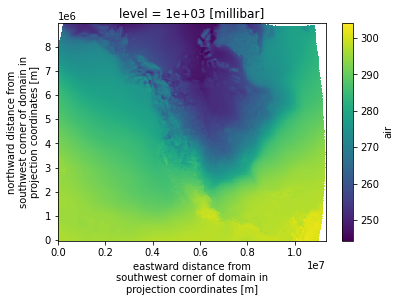

In [9]:
ds_target.air.isel(level=0).mean("time").plot()